In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 
from itertools import permutations
import warnings
warnings.filterwarnings("ignore")

In [2]:
b_health_class = pd.read_csv('B.HEALTH classification.csv')
b_health_comp = pd.read_csv('B.Health components.csv')
sleep_qual_class = pd.read_csv('SleepQual classification.csv')
sleep_qual_comp = pd.read_csv('SleepQual components.csv')

b_health_class['subject'] = b_health_class['subject'].ffill()
b_health_comp['subject'] = b_health_comp['subject'].ffill()
sleep_qual_class['subject'] = sleep_qual_class['subject'].ffill()
sleep_qual_comp['subject'] = sleep_qual_comp['subject'].ffill()

merged = b_health_class.merge(b_health_comp, on=['subject', 'day'], how='inner', suffixes=('', '_bhc'))
merged = merged.merge(sleep_qual_class, on=['subject', 'day'], how='inner', suffixes=('', '_sqc'))
merged = merged.merge(sleep_qual_comp, on=['subject', 'day'], how='inner', suffixes=('', '_sqcomp'))

print(f"Merged data shape: {merged.shape}")

Merged data shape: (182, 51)


In [3]:
merged

,subject,day,step count,distance travelled (km),calories burnt (kcal),acive time (minutes),actual sleep duration (minutes),sleep onset latency (minutes),duration in bed (minutes),efficiency (%),...,deep sleep percentage (%)_sqc,REM percentage(%),label_sqc,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6,SleepQual
0,1.0,1,3016,2.28,2151,32,455,29.0,518,88.000000,...,12.548263,24.000000,0,1,0,0,3,0,0,4
1,1.0,2,1790,1.39,2129,19,320,10.0,360,89.000000,...,33.300000,13.800000,0,0,2,0,0,0,1,2
2,1.0,3,2864,2.07,2032,29,453,23.0,504,90.000000,...,11.111111,26.000000,0,1,0,0,3,0,1,4
3,1.0,4,1419,1.80,1713,15,449,32.5,518,87.000000,...,10.424710,27.000000,1,2,0,0,3,0,1,5
4,1.0,5,1698,1.30,1725,18,358,21.0,403,89.000000,...,13.895782,23.000000,1,1,2,0,3,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,24.0,3,6752,4.59,222,67,570,2.5,575,99.130435,...,17.391304,20.434783,0,0,0,0,0,0,0,0
178,24.0,4,6207,3.89,201,61,535,5.5,546,97.985348,...,10.073260,21.978022,0,0,0,0,0,0,0,0
179,24.0,5,6202,4.21,204,67,480,0.0,480,100.000000,...,4.166667,23.958333,0,0,0,0,0,1,0,1
180,24.0,6,1011,0.23,19,21,300,32.5,365,82.191781,...,8.767123,18.356164,2,2,3,1,3,1,1,11


#### Observed Features
- `total phone usage / day (minutes)`: total phone usage in minutes
- `night time phone usage / day (minutes)`: phone usage in minutes during the night
- `awake percentage (%)`: percentage of time in bed spent awake
- `sleep onset latency (minutes)`: time it takes to fall asleep in minutes
- `actual sleep duration (minutes)`: actual sleep duration in minutes


In [4]:
feature_cols = [
    'total phone usage / day (minutes)',
    'night time phone usage / day (minutes)',
    'awake percentage (%)',
    'sleep onset latency (minutes)',
    'actual sleep duration (minutes)'
]

sleep = merged[feature_cols + ['SleepQual']].copy()

# the lower the score, the better the sleep quality
def sleep_level(x):
    if x <= 3: return 0
    elif x <= 6: return 1
    else: return 2

sleep['Sleep_Quality_State'] = sleep['SleepQual'].apply(sleep_level)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(sleep[feature_cols])

states = sleep['Sleep_Quality_State'].values
n_states = len(np.unique(states))

print(f"Number of states: {n_states}")
print(f"State distribution: {np.bincount(states)}")
print(f"X_scaled shape: {X_scaled.shape}")

Number of states: 3
State distribution: [95 58 29]
X_scaled shape: (182, 5)


In [5]:
# Initialize HMM
model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=200, init_params="", random_state=63)

# Uniform start prob
model.startprob_ = np.ones(n_states) / n_states
print(f"Start prob: {model.startprob_}")

# Transition matrix
A = np.random.rand(n_states, n_states)
A = A / A.sum(axis=1, keepdims=True)
model.transmat_ = A
print(f"Transition matrix:\n{model.transmat_}")

# Emission matrix
means = []
covs = []

for s in np.unique(states):
    X_s = X_scaled[states == s]
    means.append(X_s.mean(axis=0))
    covs.append(np.cov(X_s.T) + 1e-3 * np.eye(X_s.shape[1]))

model.means_ = np.array(means)
model.covars_ = np.array(covs)

print(f"Means shape: {model.means_.shape}")

Start prob: [0.33333333 0.33333333 0.33333333]
Transition matrix:
[[0.23818226 0.30319308 0.45862465]
 [0.45806488 0.28306046 0.25887466]
 [0.20503919 0.46241304 0.33254777]]
Means shape: (3, 5)


In [6]:
model.fit(X_scaled)

,n_components,3
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,63


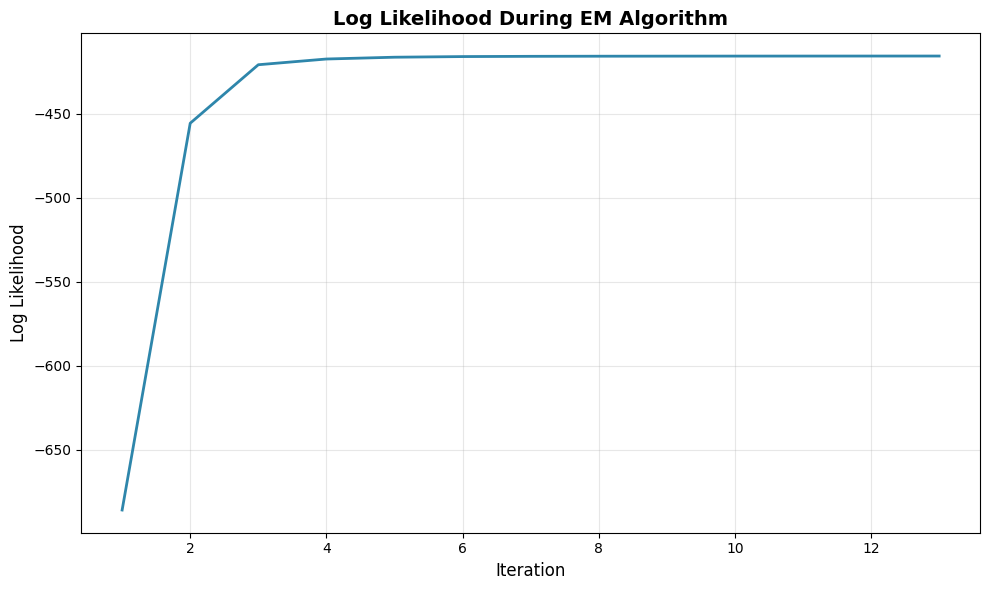


Initial log likelihood: -685.75
Final log likelihood: -415.80
Improvement: 269.94


In [7]:
log_likelihoods = model.monitor_.history

# Plot log likelihood vs iterations
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(log_likelihoods) + 1), log_likelihoods, linewidth=2, color='#2E86AB')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Log Likelihood', fontsize=12)
plt.title('Log Likelihood During EM Algorithm', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nInitial log likelihood: {log_likelihoods[0]:.2f}")
print(f"Final log likelihood: {log_likelihoods[-1]:.2f}")
print(f"Improvement: {log_likelihoods[-1] - log_likelihoods[0]:.2f}")

In [8]:
hidden_states = model.predict(X_scaled)
sleep['Predicted_Sleep_Quality'] = hidden_states

In [9]:
sleep

,total phone usage / day (minutes),night time phone usage / day (minutes),awake percentage (%),sleep onset latency (minutes),actual sleep duration (minutes),SleepQual,Sleep_Quality_State,Predicted_Sleep_Quality
0,730,686,11.000000,29.0,455,4,1,1
1,532,425,5.000000,10.0,320,2,0,1
2,699,621,9.000000,23.0,453,4,1,1
3,729,672,12.000000,32.5,449,5,1,1
4,850,794,10.000000,21.0,358,6,1,1
...,...,...,...,...,...,...,...,...
177,130,56,0.869565,2.5,570,0,0,0
178,126,46,2.014652,5.5,535,0,0,0
179,215,185,0.000000,0.0,480,1,0,0
180,467,283,17.808219,32.5,300,11,2,2



Viterbi reconstruction accuracy: 0.7802197802197802
MAE: 0.22527472527472528

Confusion Matrix:
[[78 16  1]
 [ 8 38 12]
 [ 0  3 26]]


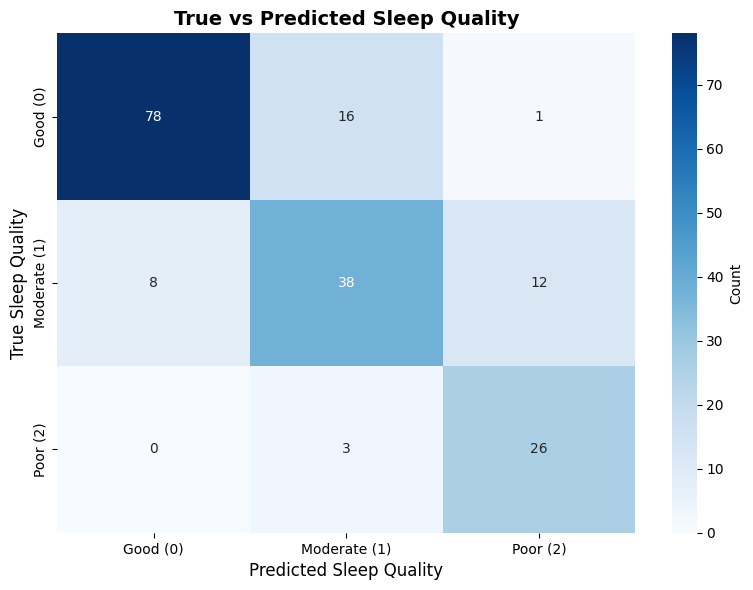

In [10]:
# Accuracy
accuracy = np.mean(hidden_states == states)
print(f"\nViterbi reconstruction accuracy: {accuracy}")

# Mean Absolute Error
mae = np.mean(np.abs(sleep['Sleep_Quality_State'] - sleep['Predicted_Sleep_Quality']))
print("MAE:", mae)

# Confusion Matrix
cm = confusion_matrix(states, hidden_states)
print(f"\nConfusion Matrix:\n{cm}")

# Heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Good (0)', 'Moderate (1)', 'Poor (2)'],
            yticklabels=['Good (0)', 'Moderate (1)', 'Poor (2)'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Sleep Quality', fontsize=12)
plt.ylabel('True Sleep Quality', fontsize=12)
plt.title('True vs Predicted Sleep Quality', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()